In [62]:
# import necessary packages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
from collections import defaultdict
import seaborn as sns
# packages for feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Clustering to see where the algorithm groups text together 
from sklearn.cluster import KMeans , AgglomerativeClustering

warnings.filterwarnings(action='ignore')

In [2]:
# reading in the opinions from appellate court 
df = pd.read_csv('C:/Users/tiamm/Documents/GitHub/Benchmarks-F19/data/opinions_data_csv/new_case_data.csv')

# read in the opinions from the supreme court 
df_sjc = pd.read_csv('C:/Users/tiamm/Documents/GitHub/Benchmarks-F19/data/opinions_data_csv/new_sjc_data.csv')

# read in the previous groups data 
old_data_criminal = pd.read_csv('C:/Users/tiamm/Documents/GitHub/Benchmarks-F19/data/previous_gp/cases_criminal.csv')
old_data_civil = pd.read_csv('C:/Users/tiamm/Documents/GitHub/Benchmarks-F19/data/previous_gp/cases_civil.csv')



In [4]:
# here we are going to format our data to be the same casing of values
for idx , _  in df.iterrows():
    
    if df.loc[idx,'case status'] == "Affirm":
        df.loc[idx,'case status'] = "affirm"
        

    elif df.loc[idx,'case status'] == "reversed":
        df.loc[idx,'case status'] = 'reverse'
   

    elif df.loc[idx,'case status'] == 'partially reversed':
        df.loc[idx,'case status'] = 'partially reverse'
     


In [5]:
# here we are going to do the same thing except for the supreme court cases 
for idx , _  in df_sjc.iterrows():
    if df_sjc.loc[idx,'appealed'] == "Yes":
        df_sjc.loc[idx,'appealed'] = 'reverse'
        
    elif df_sjc.loc[idx,'appealed'] == "No":
        df_sjc.loc[idx,'appealed'] = 'affirm'
    
    else:
        df_sjc.loc[idx,'appealed'] = 'partially reversed'
# df_sjc.rename(columns={'judge':'lower court judge','appealed':'case status'},inplace=True)

In [7]:
# make sure that both dataframe have the same column names 
df_sjc.rename(columns={'judge':'lower court judge','appealed':'case status'},inplace=True)

In [8]:
# concat the dataframes to have all the opinions in one dataframe for analysis 
data_ = pd.concat([df,df_sjc],axis=0)
data_ = data_.sample(frac=1) # this will randomly shuffle the data for us 
# fill the nan values with empty string 
data_.fillna('',inplace=True)

data_affirm = data_[data_['case status'] == 'affirm']
data_reverse = data_[data_['case status'] == 'reverse']
# filter out the case title from what we are going to analyze 
# and drop the columns
info_abt_data = data_.filter(['cases','type','lower court judge'])

data_.drop(['type','cases','caseid'],axis=1,inplace=True)



## Here we are going to CountVectorizer on our different case dataframes 
- trying to see unique features between headnotes and the opinion text itself 


In [124]:
def TfidfVectText(df,ngram,col):
    '''
        Input:
                df: dataframe of opinions 
                col: column we are trying to fit and transform vectorizer either headnote or text
                ngram: boolean value to determing the analyzer to use 
                
        Output: 
                cv1.get_feature_names() : gives us the unique word or phrase features
                v1 : the term-document matrix 
    '''
    
    if ngram == True and col == 'headnote':
        cv1 = TfidfVectorizer(lowercase=True,stop_words='english',max_features=50,
                      ngram_range=(2,3),max_df=.55,min_df = 5)

        v1 = cv1.fit_transform(df['headnote'])
    
    elif ngram == False and col == 'headnote':
        cv1 = TfidfVectorizer(lowercase=True,stop_words='english',max_features=50,
                      analyzer='word',max_df=.55,min_df = 5)

        v1 = cv1.fit_transform(df['headnote'])
        
    elif ngram == True and col == 'text':
        cv1 = TfidfVectorizer(lowercase=True,stop_words='english',max_features=50,
                      ngram_range=(2,3),max_df=.55,min_df = 5)

        v1 = cv1.fit_transform(df['text'])
    
    else:
        cv1 = TfidfVectorizer(lowercase=True,stop_words='english',max_features=50,
                      analyzer='word',max_df=.55,min_df = 5)

        v1 = cv1.fit_transform(df['text'])
    
    return cv1.get_feature_names() , v1
        
            

In [10]:
def CountVectText(df,ngram,col):
    '''
        Input:
                df: dataframe of opinions 
                col: column we are trying to fit and transform vectorizer either headnote or text
                ngram: boolean value to determing the analyzer to use 
                
        Output: 
                cv1.get_feature_names() : gives us the unique word or phrase features
                v1 : the term-document matrix 
    '''
    
    if ngram == True and col == 'headnote':
        cv1 = CountVectorizer(lowercase=True,stop_words='english',max_features=50,
                      ngram_range=(2,3),max_df=.55,min_df = 5)
        
        v1 = cv1.fit_transform(df['headnote'])
    
    elif ngram == False and col == 'headnote':
        cv1 = CountVectorizer(lowercase=True,stop_words='english',max_features=50,
                      analyzer='word',max_df=.55,min_df = 5)

        v1 = cv1.fit_transform(df['headnote'])
        
    elif ngram == True and col == 'text':
        cv1 = CountVectorizer(lowercase=True,stop_words='english',max_features=50,
                      ngram_range=(2,3),max_df=.55,min_df = 5)

        v1 = cv1.fit_transform(df['text'])
    
    else:
        cv1 = CountVectorizer(lowercase=True,stop_words='english',max_features=50,
                      analyzer='word',max_df=.55,min_df = 5)

        v1 = cv1.fit_transform(df['text'])
    
    return cv1.get_feature_names() , v1
        
            

In [11]:
def union_(feats1, feats2, type_analyzer):
   '''
        Input:
                feats1 / feats2: the cv1.get_feature_names() from the previous functions. This is used to 
                                 compare features of affirmed and reversed cases 
                                
                type_analyzer: string value that is ngram or word depending on your input for ngram in previous functions
                
        Output: how many features did affirm and reverse cases have in common as an integer and as a percentage
                
    '''
    
    # going to give use the percent of the features that both affirmed or reversed 
    counter = 0
    
    for string in feats1:
        if string in feats2:
            counter += 1  
        
    print(f"the number of word vectorizers from analyzing have in common utilizing {type_analyzer}: {counter}")
    print(f"There is a {counter / 50} percent overlap between the frequent words in both types of cases")

In [126]:
def elbow_plot(df,k):
    ''' 
        Input: 
                df: dataframe for clustering
                k: number of clusters you want to plot 
                
        Output: plot of distoritions of varying k clusters
    '''
    # Here we are going to make an elbow plot of the data 
    
    distortions = []
    for i in range(1, k):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=300)
        km.fit(pca_result)
        distortions.append(km.inertia_)

    # plot
    plt.plot(range(1, k), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()


In [12]:
feats1 , mat1 = CountVectText(data_affirm,ngram=True,col='headnote')
feats2 , mat2 = CountVectText(data_reverse,ngram=True,col='headnote')

union_(feats1,feats2,type_analyzer='ngram')

the number of word vectorizers from analyzing have in common utilizing ngram: 29
There is a 0.58 percent overlap between the frequent words in both types of cases


In [13]:
feats3 , mat3 = CountVectText(data_affirm,ngram=False,col='headnote')
feats4 , mat4 = CountVectText(data_reverse,ngram=False,col='headnote')

union_(feats3,feats4,type_analyzer='word')

the number of word vectorizers from analyzing have in common utilizing word: 33
There is a 0.66 percent overlap between the frequent words in both types of cases


In [14]:
feats5 , mat5 = CountVectText(data_affirm,ngram=True,col='text')
feats6 , mat6 = CountVectText(data_reverse,ngram=True,col='text')

union_(feats5,feats6,type_analyzer='ngram')

the number of word vectorizers from analyzing have in common utilizing ngram: 34
There is a 0.68 percent overlap between the frequent words in both types of cases


In [15]:
feats7 , mat7 = CountVectText(data_affirm,ngram=False,col='text')
feats8 , mat8 = CountVectText(data_reverse,ngram=False,col='text')

union_(feats7,feats8,type_analyzer='word')

the number of word vectorizers from analyzing have in common utilizing word: 29
There is a 0.58 percent overlap between the frequent words in both types of cases


##  Next, we are going to repeat this process except that we are going to be using a TfidfVectorizer, to see if the weight of the inverse of the inverse document frequency rate would alter our results.

In [16]:
feats_1 , mat_1 = TfidfVectText(data_affirm,ngram=True,col='headnote')
feats_2 , mat_2 = TfidfVectText(data_reverse,ngram=True,col='headnote')

union_(feats_1,feats_2,type_analyzer='ngram')

the number of word vectorizers from analyzing have in common utilizing ngram: 29
There is a 0.58 percent overlap between the frequent words in both types of cases


In [17]:
feats_3 , mat_3 = TfidfVectText(data_affirm,ngram=False,col='headnote')
feats_4 , mat_4 = TfidfVectText(data_reverse,ngram=False,col='headnote')

union_(feats_3,feats_4,type_analyzer='word')

the number of word vectorizers from analyzing have in common utilizing word: 33
There is a 0.66 percent overlap between the frequent words in both types of cases


In [18]:
feats_5 , mat_5 = TfidfVectText(data_affirm,ngram=True,col='text')
feats_6 , mat_6 = TfidfVectText(data_reverse,ngram=True,col='text')

union_(feats_5,feats_6,type_analyzer='ngram')

the number of word vectorizers from analyzing have in common utilizing ngram: 34
There is a 0.68 percent overlap between the frequent words in both types of cases


In [19]:
feats_7 , mat_7 = TfidfVectText(data_affirm,ngram=False,col='text')
feats_8 , mat_8 = TfidfVectText(data_reverse,ngram=False,col='text')

union_(feats_7,feats_8,type_analyzer='word')

the number of word vectorizers from analyzing have in common utilizing word: 29
There is a 0.58 percent overlap between the frequent words in both types of cases


In [73]:
# concatentate the values for both affirm and reverse cases and use for clustering
# chose these matricies because they had among the least features in common, so hopefully 
# those differences could help identify certain patterns
analyze_mat1= np.concatenate((mat_7.toarray(),mat_8.toarray()),axis=0)

### In here based on the vectorizers, it is rather difficult to find unique words that soley belong to either affirmed or reversed cases, as the lowest intersection of affirm and reverse cases is fifty percent. While this can make sense, for instance certain words are always going to appear such as certain judicial terminology, adjectives like: and more, however, viewing these features as a way to distinguish these two types of cases is rather difficult and will require significantly more data.



### Now we are going to try to cluster these cases based on these features. For this code, I am going to compare the features that cases have the most and the least in common

In [74]:
# This is going to be the features that all of the 
analyze_mat1 = pd.DataFrame(analyze_mat1, columns=feats_7)

In [75]:
# Terms we are going to ignore because they didn't have benefit for including / we already have 
# officer and we do not need to repeat terms.
analyze_mat1.drop(['officers','united','notice','grand','board','act','vehicle','cell'],axis=1,inplace=True)

,abuse,act,action,board,cases,cause,child,complaint,conduct,conviction,...,states,statute,substantial,testified,testimony,use,vehicle,victim,violation,years
0,0.000000,0.486171,0.000000,0.687783,0.000000,0.025283,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.336790,0.023515,0.000000,0.000000,0.022741,0.000000,0.000000,0.101131,0.048251
1,0.045790,0.008211,0.030614,0.000000,0.021360,0.016226,0.132294,0.000000,0.061053,0.000000,...,0.000000,0.000000,0.022637,0.008518,0.000000,0.000000,0.010454,0.000000,0.000000,0.000000
2,0.000000,0.130559,0.608482,0.097481,0.000000,0.129002,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.061372,0.059991,0.000000,0.000000,0.638188,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.055336,0.000000,0.231654,0.029329,0.039855,0.000000,0.027590,0.032094,...,0.106996,0.195346,0.027279,0.000000,0.000000,0.000000,0.000000,0.202429,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.251020,0.000000,0.000000,...,0.000000,0.043087,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.177682,0.031861,0.000000,0.047577,0.082883,0.000000,0.427790,0.034902,0.059227,0.068898,...,0.028711,0.000000,0.322079,0.033054,0.000000,0.000000,0.000000,0.217280,0.000000,0.060080
6,0.000000,0.000000,0.000000,0.000000,0.270148,0.000000,0.000000,0.042660,0.036196,0.126318,...,0.000000,0.036612,0.000000,0.040402,0.352610,0.069221,0.297482,0.000000,0.038478,0.000000
7,0.000000,0.199644,0.148873,0.059625,0.138494,0.000000,0.000000,0.393659,0.111337,0.000000,...,0.035982,0.150156,0.036694,0.000000,0.000000,0.000000,0.000000,0.000000,0.039453,0.112941
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035726,0.000000,0.000000,0.028769,...,0.000000,0.000000,0.097810,0.000000,0.080308,0.000000,0.000000,0.846795,0.052581,0.000000
9,0.045297,0.000000,0.015142,0.000000,0.014086,0.032102,0.872463,0.000000,0.075495,0.052693,...,0.014639,0.030545,0.089573,0.050560,0.179776,0.187688,0.000000,0.018464,0.016051,0.030633


In [81]:
# we are going to use Principal Component Analysis 
pca = PCA(n_components=3)
pca_result = pca.fit_transform(analyze_mat1)
pca_result = pd.DataFrame(pca_result,columns=['component1','component2','component3'])
pca_result # going to be a dataframe object 

,component1,component2,component3
0,-0.261258,-0.051668,-0.446783
1,-0.019483,-0.212081,-0.102182
2,-0.301701,0.182097,0.036393
3,-0.030783,0.057553,-0.006450
4,-0.371204,0.260879,-0.118438
5,0.169535,-0.220241,-0.197608
6,-0.015481,-0.235810,0.323407
7,-0.286540,0.164952,-0.122861
8,0.727438,0.346087,-0.083061
9,0.010573,-0.156350,-0.015010


In [90]:
# Here we are going to create a dictionary that has the indicies of every row that is apart of that 
# particular cluster 
cluster_2_id = defaultdict(list)

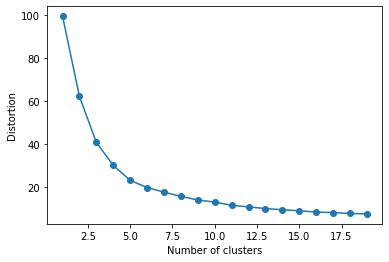

In [127]:
elbow_plot(pca_result,20) # going to determine number of clusters to use

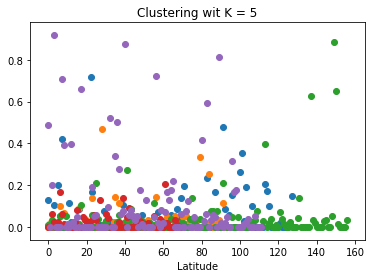

Here is our inertia, or the summation of the variance per cluster:23.27783339763632


In [133]:
# Now we are going to run KMeans when k = 5 
km = KMeans(n_clusters=5, init='k-means++',
            n_init=10, max_iter=300)
km.fit(pca_result)
res = km.predict(pca_result)

fig, ax = plt.subplots()
for i in range(5): # loop through cluster 
    pts = np.array([analyze_mat1.to_numpy()[j,:] for j in range(len(analyze_mat1)) if res[j] == i])
    
    # here we are getting the indicies
    cluster_2_id[i] = [j for j in range(len(analyze_mat1)) if res[j] == i]

    ax.scatter(list(range(len(pts))), pts[:, 1])
plt.title(f'Clustering wit K = 5')
plt.xlabel('Latitude')
plt.ylabel('')
plt.show()

print(f"Here is our inertia, or the summation of the variance per cluster:{km.inertia_}")

In [93]:
data_by_verdict = pd.concat([data_affirm,data_reverse],axis=0)

## We are going to manually search for our information

In [107]:
cluster1 = data_by_verdict.iloc[cluster_2_id[0],:]
cluster1['type'].values_count()

             80
sjc-12162     1
sjc-12510     1
sjc-12455     1
sjc-12369     1
             ..
sjc-12527     1
sjc-12694     1
sjc-12339     1
sjc-12514     1
sjc-12394     1
Name: caseid, Length: 74, dtype: int64

In [112]:
cluster = data_by_verdict.iloc[cluster_2_id[1],:]
cluster2['caseid'].value_counts()


             43
sjc-12556     1
sjc-12580     1
sjc-12061     1
sjc-12374     1
sjc-11573     1
sjc-12363     1
sjc-12560     1
sjc-11666     1
sjc-12501     1
sjc-12590     1
sjc-12456     1
sjc-12300     1
sjc-12263     1
sjc-09265     1
sjc-12579     1
sjc-12479     1
sjc-11387     1
sjc-12415     1
sjc-11507     1
sjc-12468     1
sjc-12491     1
sjc-12437     1
sjc-12313     1
sjc-11950     1
sjc-12417     1
sjc-12689     1
sjc-11125     1
sjc-12321     1
sjc-12640     1
sjc-12467     1
sjc-12216     1
sjc-12358     1
sjc-12190     1
sjc-12319     1
sjc-11610     1
sjc-12633     1
sjc-12519     1
sjc-10776     1
sjc-12335     1
sjc-11675     1
sjc-12324     1
sjc-10222     1
sjc-12088     1
sjc-12400     1
sjc-12244     1
sjc-12651     1
sjc-08635     1
sjc-12639     1
sjc-12396     1
sjc-12624     1
sjc-12429     1
sjc-12605     1
sjc-12549     1
Name: caseid, dtype: int64

In [114]:
cluster3 = data_by_verdict.iloc[cluster_2_id[2],:]
cluster3['case status'].value_counts()


affirm     90
reverse    41
Name: case status, dtype: int64

In [118]:
cluster4 = data_by_verdict.iloc[cluster_2_id[3],:]
cluster4['type'].value_counts()


criminal    68
civil        1
Name: type, dtype: int64

In [119]:
cluster5 = data_by_verdict.iloc[cluster_2_id[4],:]
cluster5['type'].value_counts()


civil       103
criminal      9
Name: type, dtype: int64

###  going to visualize a 3d scatter plot; the 2d representation was not good  because the matrix we are analyzing is very sparse.

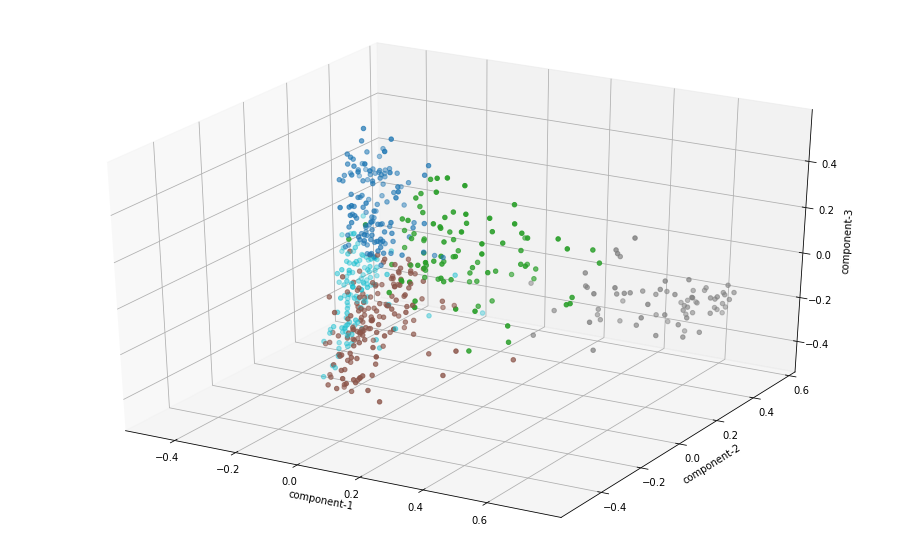

In [134]:
ax = plt.figure(figsize=(16,10)).add_subplot(111,projection='3d')


ax.scatter(
    xs=pca_result.loc[:,"component1"], 
    ys=pca_result.loc[:,"component2"], 
    zs = pca_result.loc[:,'component3'],
    c=res, 
    cmap='tab10'
)

ax.set_xlabel('component-1')
ax.set_ylabel('component-2')
ax.set_zlabel('component-3')
plt.show()

### So here is our clustering. We set k = 5. I dropped some vocabulary terms from the text_document frequency matrix, and then used prinicpal components in order to make it possible to plot our data onto 3 dimensional space. There are still a few problems in terms of visualizations. So our interia_ for this clustering is 5, which may seem small and a good things for less variance per cluster, however because the values of matrix are often less than 1, we still see high variation between the clusters. Since we cannot determine what documents get deleted after running the algorithm, it makes interpreting each cluster that much more difficult. 


### Our term-frequency matrix that utilized Tfidf, we were able to find that although it has some cluster variability, that 


## Here is information about the clustering

- cluster 1: 153 opinions
    - 112 criminal cases and 39 civil cases 
    - 101 affirmed cases and 52 reversed cases 
    
    
- cluster 2: 96 opinions 
    - 85 criminal cases and 11 civil cases 
    - 75 affirmed and 21 reversed 
   
- cluster 3: 131 opinions 
    - 116 criminal cases and 15 civil cases 
    - 90 affirmed and 41 reversed
    

- cluster 4: 69 opinions 
    - 68 criminal and 1 civil
    - 56 affirm and 13 reverse 

- cluster 5: 112 opinions
    - 103 criminal cases and 9 civil cases
    - 100 affirmed and 12 reversed.
    
## while cluster 5  and 4 were able to identify more criminal and civil cases, there is not consistency between these clusters and affirmed or reverse cases; They all have the trend of more criminal than civil cases and all have more affirmed than reverse cases. This means that the unique features extracted from the text are not clear enough for the algorithm to be able to distinguish between the varying cases